In [1]:
import keras.layers as KL
from keras.models import Model
import keras.backend as K
import tensorflow as tf
import numpy as np
import utils
import proposal_func
import detection_target_fixed
from classifier_fixed import fpn_classifiler
import keras

Using TensorFlow backend.


In [2]:
from utilsV3 import shapeData as dataSet
from config import Config

config = Config()
dataset = dataSet([64,64], config=config)

In [3]:
class BatchNorm(KL.BatchNormalization):
    def call(self, inputs, training=None):
        return super(self.__class__, self).call(inputs, training=False)

In [4]:
def building_block(filters, block):
    if block !=0 :
        stride = 1
    else:
        stride = 2
    def f(x):
        y = KL.Conv2D(filters, (1,1), strides=stride)(x)
        y = BatchNorm(axis=3)(y)
        y = KL.Activation("relu")(y)
        
        y = KL.Conv2D(filters, (3,3), padding="same")(y)
        y = BatchNorm(axis=3)(y)
        y = KL.Activation("relu")(y)
        
        y = KL.Conv2D(4*filters, (1,1))(y)
        y = BatchNorm(axis=3)(y)
        
        if block == 0:
            shorcut = KL.Conv2D(4*filters, (1,1), strides=stride)(x)
            shorcut = BatchNorm(axis=3)(shorcut)
        else:
            shorcut = x
        y = KL.Add()([y, shorcut])
        y = KL.Activation("relu")(y)
        return y
    return f

In [5]:
def resNet_featureExtractor(inputs):
    x = KL.Conv2D(64, (3,3), padding="same")(inputs)
    x = BatchNorm(axis=3)(x)
    x = KL.Activation("relu")(x)
    
    filters = 64
    blocks = [6, 6, 6]
    for i, block_num in enumerate(blocks):
        for block_id in range(block_num):
            x = building_block(filters, block_id)(x)
        filters *= 2
    return x

In [6]:
def rpn_net(inputs, k):
    shared_map = KL.Conv2D(256, (3,3), padding="same")(inputs)
    shared_map = KL.Activation("linear")(shared_map)
    rpn_class = KL.Conv2D(2*k, (1,1))(shared_map)
    rpn_class = KL.Lambda(lambda x: tf.reshape(x, [tf.shape(x)[0],-1,2]))(rpn_class)
    rpn_class = KL.Activation("linear")(rpn_class)
    rpn_prob = KL.Activation("softmax")(rpn_class)
    
    y = KL.Conv2D(4*k, (1,1))(shared_map)
    y = KL.Activation("linear")(y)
    rpn_bbox = KL.Lambda(lambda x: tf.reshape(x, [tf.shape(x)[0],-1,4]))(y)
    return rpn_class, rpn_prob, rpn_bbox

In [7]:
def rpn_class_loss(rpn_match, rpn_class_logits):
    ## rpn_match (None, 576, 1)
    ## rpn_class_logits (None, 576, 2)
    rpn_match = tf.squeeze(rpn_match, -1)
    indices = tf.where(K.not_equal(rpn_match, 0))
    anchor_class = K.cast(K.equal(rpn_match, 1), tf.int32)
    rpn_class_logits = tf.gather_nd(rpn_class_logits, indices)     ### prediction
    anchor_class = tf.gather_nd(anchor_class, indices)   ### target
    loss = K.sparse_categorical_crossentropy(target=anchor_class, output=rpn_class_logits, from_logits=True)
    loss = K.switch(tf.size(loss) > 0 , K.mean(loss), tf.constant(0.0))
    return loss

def batch_back(x, counts, num_rows):
    outputs = []
    for i in range(num_rows):
        outputs.append(x[i, :counts[i]])
    return tf.concat(outputs, axis=0)


def rpn_bbox_loss(target_bbox, rpn_match, rpn_bbox):
    rpn_match = tf.squeeze(rpn_match, -1)
    indices = tf.where(K.equal(rpn_match, 1))
    rpn_bbox = tf.gather_nd(rpn_bbox, indices)
    batch_counts = K.sum(K.cast(K.equal(rpn_match, 1), tf.int32), axis=1)
    target_bbox = batch_back(target_bbox, batch_counts, 20)
    diff = K.abs(target_bbox - rpn_bbox)
    less_than_one = K.cast(K.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
    loss = K.switch(tf.size(loss) > 0 , K.mean(loss), tf.constant(0.0))
    return loss

def smooth_l1_loss(y_true, y_pred):
    diff = K.abs(y_true - y_pred)
    less_than_one = K.cast(K.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
    return loss

def mrcnn_bbox_loss_graph(target_bbox, target_class_ids, pred_bbox):

    target_class_ids = K.reshape(target_class_ids, (-1,))
    target_bbox = K.reshape(target_bbox, (-1, 4))
    pred_bbox = K.reshape(pred_bbox, (-1, K.int_shape(pred_bbox)[2], 4))

    positive_roi_ix = tf.where(target_class_ids > 0)[:, 0]
    positive_roi_class_ids = tf.cast(
        tf.gather(target_class_ids, positive_roi_ix), tf.int64)
    indices = tf.stack([positive_roi_ix, positive_roi_class_ids], axis=1)

    target_bbox = tf.gather(target_bbox, positive_roi_ix)
    pred_bbox = tf.gather_nd(pred_bbox, indices)

    loss = K.switch(tf.size(target_bbox) > 0,
                    smooth_l1_loss(y_true=target_bbox, y_pred=pred_bbox),
                    tf.constant(0.0))
    loss = K.mean(loss)
    loss = K.reshape(loss, [1, 1])
    return loss

def mrcnn_class_loss_graph(target_class_ids, pred_class_logits,
                           active_class_ids):
    target_class_ids = tf.cast(target_class_ids, 'int64')
    print("active_class_ids", active_class_ids)
    # Find predictions of classes that are not in the dataset.
    pred_class_ids = tf.argmax(pred_class_logits, axis=2)
    # TODO: Update this line to work with batch > 1. Right now it assumes all
    #       images in a batch have the same active_class_ids
    pred_active = tf.gather(active_class_ids[0], pred_class_ids)

    # Loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=target_class_ids, logits=pred_class_logits)

    pred_active = tf.cast(pred_active, tf.float32)
    print("loss", loss)
    print("pred_active", pred_active)
    loss = loss * pred_active

    # Computer loss mean. Use only predictions that contribute
    # to the loss to get a correct mean.
    loss = tf.reduce_sum(loss) / tf.reduce_sum(pred_active)
    return loss

In [8]:
def mrcnn_class_loss_graphV2(target_class_ids, pred_class_logits,
                           active_class_ids, batch_size=20):
    target_class_ids = tf.cast(target_class_ids, 'int64')
    #print("target_class_ids",target_class_ids.shape)
    
    #print("pred_class_logits",pred_class_logits.shape)
    pred_class_ids = tf.argmax(pred_class_logits, axis=2)
    #print("pred_class_ids2",pred_class_ids.shape)

    #print("active_class_ids",active_class_ids[0].shape)
    #pred_active = tf.zeros((batch_size, tf.shape(target_class_ids)[1]))
    pred_active = utils.batch_slice([active_class_ids, pred_class_ids], lambda x,y:tf.gather(x,y), batch_size)
    #for i in range(batch_size):
    #    pred_active[i] = tf.gather(active_class_ids[i], pred_class_ids[i])
        #pred_active = tf.gather(active_class_ids[0], pred_class_ids)
    #print("pred_active",pred_active.shape)


    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=target_class_ids, logits=pred_class_logits)

    pred_active = tf.cast(pred_active, tf.float32)

    loss = loss * pred_active


    loss = tf.reduce_sum(loss) / tf.reduce_sum(pred_active)
    return loss


#target_class_ids = test_out[5]
#mrcnn_class_logits = test_out[8]

#input_active_ids_ = test_data[0][3]


#loss = mrcnn_class_loss_graphV2(target_class_ids, mrcnn_class_logits, input_active_ids_, 20)

#sess.run(loss)

In [9]:
import keras.engine as KE

def anchor_refinement(boxes, deltas):
    boxes = tf.cast(boxes, tf.float32)
    h = boxes[:, 2] - boxes[:, 0]
    w = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + h / 2
    center_x = boxes[:, 1] + w / 2

    center_y += deltas[:, 0] * h
    center_x += deltas[:, 1] * w
    h *= tf.exp(deltas[:, 2])
    w *= tf.exp(deltas[:, 3])
    
    y1 = center_y - h / 2
    x1 = center_x - w / 2
    y2 = center_y + h / 2
    x2 = center_x + w / 2
    boxes = tf.stack([y1, x1, y2, x2], axis=1)
    return boxes


def refine_detections(rois, probs, deltas):
    argMax_probs = tf.argmax(probs, axis=1)
    max_probs = tf.reduce_max(probs, axis=1)
    keep_idxs = tf.where(max_probs > 0.5)[:,0]
    idx_y = tf.cast(np.arange(16), tf.int32)
    idx_x = tf.cast(argMax_probs, tf.int32)
    idxs = tf.stack([idx_y, idx_x],axis=1)
    deltas_keep = tf.gather_nd(deltas, idxs)
    refined_rois = anchor_refinement(tf.cast(rois, tf.float32),
                                 tf.cast(deltas_keep * config.RPN_BBOX_STD_DEV, tf.float32))
    rois_ready = tf.gather(refined_rois, keep_idxs)
    class_ids = tf.gather(argMax_probs, keep_idxs)
    class_ids = tf.to_float(class_ids)[..., tf.newaxis]
    detections = tf.concat([rois_ready, class_ids], axis=1)
    gap = tf.maximum(16 - tf.shape(detections)[0],0)
    detections = tf.pad(detections, [(0, gap), (0, 0)], "CONSTANT")
    return detections
### NMS

class DetectionLayer(KE.Layer):

    def __init__(self, **kwargs):
        super(DetectionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        rois = inputs[0]
        probs = inputs[1]
        deltas = inputs[2]
        
        detections_batch = utils.batch_slice(
            [rois, probs, deltas],
            lambda x, y, z: refine_detections(x, y, z),
            20)
        
        #return tf.reshape(
        #    detections_batch,
        #    [16, 8, -1])
        return detections_batch

    def compute_output_shape(self, input_shape):
        return (None, 8, -1)

In [10]:
## training inference 

## RPN   all 

In [11]:
class fasterRCNN():
    def __init__(self, mode, subnet, config):
        assert mode in ["training", "inference"]
        self.mode = mode
        self.config = config
        self.subnet = subnet
        self.keras_model = self.build(mode=mode, subnet=subnet, config=config)
    
    def build(self, mode, subnet, config):
        
        assert mode in ["training", "inference"]
        input_image = KL.Input(shape=[64,64,3], dtype=tf.float32)
        input_bboxes = KL.Input(shape=[None,4], dtype=tf.float32)
        input_class_ids = KL.Input(shape=[None],dtype=tf.int32)
        input_active_ids = KL.Input(shape=[4,], dtype=tf.int32)
        input_rpn_match = KL.Input(shape=[None, 1], dtype=tf.int32)
        input_rpn_bbox = KL.Input(shape=[None, 4], dtype=tf.float32)
        
        h, w = config.image_size[: 2]
        image_scale = K.cast(K.stack([h,w,h,w], axis=0), tf.float32)
        gt_bboxes = KL.Lambda(lambda x: x / image_scale)(input_bboxes)

        feature_map = resNet_featureExtractor(input_image)
        rpn_class, rpn_prob, rpn_bbox = rpn_net(feature_map, 9)

        anchors = utils.anchor_gen(featureMap_size=[8, 8], ratios=config.ratios, scales=config.scales,\
                                   rpn_stride=config.rpn_stride,anchor_stride=config.anchor_stride)

        proposals = proposal_func.proposal(proposal_count=16, nms_thresh=0.7, anchors=anchors, \
                                           batch_size=20, config=config)([rpn_prob, rpn_bbox])
        if mode == "training":
            target_rois, target_class_ids, target_delta, target_bboxes = detection_target_fixed.DetectionTarget(config=config, \
                              name="proposal_target")([proposals,input_class_ids,gt_bboxes])
            denomrlaize_rois = KL.Lambda(lambda x:8.0*x, name="denormalized_rois")(target_rois)
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox = fpn_classifiler(feature_map, denomrlaize_rois, 20, 21, 7, 4)
            
            loss_rpn_match = KL.Lambda(lambda x: rpn_class_loss(*x), name="loss_rpn_match")([input_rpn_match, rpn_class])

            loss_rpn_bbox = KL.Lambda(lambda x: rpn_bbox_loss(*x), name="loss_rpn_bbox")([input_rpn_bbox, input_rpn_match, rpn_bbox])

            bbox_loss = KL.Lambda(lambda x: mrcnn_bbox_loss_graph(*x), name="bbox_loss")(
                                                [target_delta, target_class_ids, mrcnn_bbox])
            class_loss = KL.Lambda(lambda x: mrcnn_class_loss_graphV2(*x), name="mrcnn_class_loss")(
                                        [target_class_ids, mrcnn_class_logits, input_active_ids])
            
            if subnet == "rpn":
            
                model = Model([input_image, input_bboxes, input_class_ids, input_active_ids, input_rpn_match, input_rpn_bbox],
                              [feature_map, rpn_class, rpn_prob, rpn_bbox, proposals, target_rois, denomrlaize_rois,target_class_ids, target_delta, target_bboxes, \
                               loss_rpn_match, loss_rpn_bbox])
            elif subnet == "all":
                model = Model([input_image, input_bboxes, input_class_ids, input_active_ids, input_rpn_match, input_rpn_bbox],
                [feature_map, rpn_class, rpn_prob, rpn_bbox, proposals, target_rois, denomrlaize_rois,target_class_ids, target_delta, target_bboxes, \
                 mrcnn_class_logits, mrcnn_class, mrcnn_bbox, loss_rpn_match, loss_rpn_bbox, bbox_loss, class_loss])
            
        if mode == "inference":
            denomrlaize_proposals = KL.Lambda(lambda x:8.0*x, name="denormalized_proposals")(proposals)
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox = fpn_classifiler(feature_map, denomrlaize_proposals, 20, 16, 7, 4)
            detections = DetectionLayer()([proposals, mrcnn_class, mrcnn_bbox])
            
            model = Model([input_image],[detections])
            
        return model
                
    def compile_(self):
        loss_lay1 = self.keras_model.get_layer("loss_rpn_match").output
        loss_lay2 = self.keras_model.get_layer("loss_rpn_bbox").output
        if self.subnet == "all":
            loss_lay3 = self.keras_model.get_layer("bbox_loss").output
            loss_lay4 = self.keras_model.get_layer("mrcnn_class_loss").output

        self.keras_model.add_loss(tf.reduce_mean(loss_lay1))
        self.keras_model.add_loss(tf.reduce_mean(loss_lay2))
        if self.subnet == "all":
            self.keras_model.add_loss(tf.reduce_mean(loss_lay3))
            self.keras_model.add_loss(tf.reduce_mean(loss_lay4))

        self.keras_model.compile(loss=[None]*len(self.keras_model.output), optimizer=keras.optimizers.SGD(lr=0.00005, momentum=0.9))

        self.keras_model.metrics_names.append("loss_rpn_match")
        self.keras_model.metrics_tensors.append(tf.reduce_mean(loss_lay1, keep_dims=True))

        self.keras_model.metrics_names.append("loss_rpn_bbox")
        self.keras_model.metrics_tensors.append(tf.reduce_mean(loss_lay2, keep_dims=True))

        if self.subnet == "all":
            self.keras_model.metrics_names.append("bbox_loss")
            self.keras_model.metrics_tensors.append(tf.reduce_mean(loss_lay3, keep_dims=True))

            self.keras_model.metrics_names.append("mrcnn_class_loss")
            self.keras_model.metrics_tensors.append(tf.reduce_mean(loss_lay4, keep_dims=True))
        
    def training(self, dataGen):
        self.compile_()
        his = self.keras_model.fit_generator(dataGen, steps_per_epoch=20, epochs=100)
    def inference(self, testdata):
        assert self.mode == "inference"
        out = self.keras_model.predict(testdata)
        return out
    
    def save_weights(self, weights_path):
        self.keras_model.save_weights(weights_path)
        
    def load_weights(self, weights_path):
        from keras.engine import topology
        import h5py
        f = h5py.File(weights_path)
        layers = self.keras_model.layers
        topology.load_weights_from_hdf5_group_by_name(f, layers)
        

In [12]:
model = fasterRCNN(mode="training", subnet="all", config=config)

In [13]:
model.load_weights("test0910_1200_all_V2.h5")
#model.load_weights("test0909.h5")

In [14]:
def data_Gen(dataset, num_batch, batch_size, config):
    for _ in range(num_batch):
        images = []
        bboxes = []
        class_ids = []
        rpn_matchs = []
        rpn_bboxes = []
        active_ids = []
        for i in range(batch_size):
            image, bbox, class_id, active_id, rpn_match, rpn_bbox, _ = data = dataset.load_data()
            pad_num = config.max_gt_obj - bbox.shape[0]
            pad_box = np.zeros((pad_num, 4))
            pad_ids = np.zeros((pad_num, 1))
            bbox = np.concatenate([bbox, pad_box], axis=0)
            class_id = np.concatenate([class_id, pad_ids], axis=0)
        
            images.append(image)
            bboxes.append(bbox)
            class_ids.append(class_id)
            rpn_matchs.append(rpn_match)
            rpn_bboxes.append(rpn_bbox)
            active_ids.append(active_id)
        images = np.concatenate(images, 0).reshape(batch_size, config.image_size[0],config.image_size[1] , 3)
        bboxes = np.concatenate(bboxes, 0).reshape(batch_size, -1 , 4)
        class_ids = np.concatenate(class_ids, 0).reshape(batch_size, -1 )
        active_ids = np.concatenate(active_ids, 0).reshape(batch_size, -1 )
        rpn_matchs = np.concatenate(rpn_matchs, 0).reshape(batch_size, -1 , 1)
        rpn_bboxes = np.concatenate(rpn_bboxes, 0).reshape(batch_size, -1 , 4)
        rpn_bboxes = np.concatenate(rpn_bboxes, 0).reshape(batch_size, -1 , 4)
        yield [images, bboxes, class_ids, active_ids, rpn_matchs, rpn_bboxes],[]

In [15]:
dataGen = data_Gen(dataset, 35000, 20, config)

In [16]:
model.training(dataGen)

/home/jon-liu/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
20/20 [==============================] - 22s 1s/step - loss: 0.6564 - loss_rpn_match: 0.0232 - loss_rpn_bbox: 0.1912 - bbox_loss: 0.1955 - mrcnn_class_loss: 0.2465
Epoch 2/100
20/20 [==============================] - 6s 285ms/step - loss: 0.6646 - loss_rpn_match: 0.0239 - loss_rpn_bbox: 0.1990 - bbox_loss: 0.1996 - mrcnn_class_loss: 0.2421
Epoch 3/100
 6/20 [========>.....................] - ETA: 3s - loss: 0.7348 - loss_rpn_match: 0.0234 - loss_rpn_bbox: 0.2406 - bbox_loss: 0.2275 - mrcnn_class_loss: 0.2433

KeyboardInterrupt: 

In [17]:
#model.save_weights("rpn_1103_aaa.h5")

In [18]:
#model.load_weights("test0908.h5")

In [19]:
test_data = next(dataGen)

In [20]:
out = model.inference(test_data[0][0])

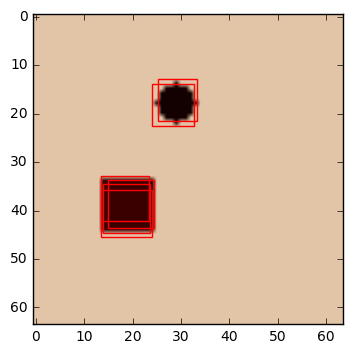

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
%matplotlib inline

ix = random.sample(range(20), 1)[0]

image = test_data[0][0][ix]

boxes_result = out[ix][:,:4] * 64
id_result = out[ix][:,4]

plt.imshow(image)
Axs = plt.gca()

pos_idxs = np.where(id_result > 0)[0]

for i in range(pos_idxs.shape[0]):
    id_ = pos_idxs[i]
    box = boxes_result[id_]
    rec = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], 
                           edgecolor="r", facecolor="none")
    Axs.add_patch(rec)

In [24]:
np.where(pos_idxs)[0]

array([], dtype=int64)

In [99]:
#rpn_class, rpn_prob, rpn_bbox, proposals, mrcnn_class_logits, mrcnn_class, mrcnn_bbox

proposals_model = out[3]
probs = out[5]
deltas_infe = out[-1]

print(proposals_model.shape)
print(probs.shape)
print(deltas_infe.shape)

(16, 5)
(16, 5)
(16, 5)


In [100]:
import random

sess = tf.Session()

ix = random.sample(range(20), 1)[0]
images = test_data[0][0]
image_ = images[ix]
rois_ = proposals_model[ix]
probs_ = probs[ix]
deltas = deltas_infe[ix]


def refine_detections(rois, probs, deltas):
    argMax_probs = tf.argmax(probs, axis=1)
    max_probs = tf.reduce_max(probs, axis=1)
    print("max_probs",sess.run(max_probs))
    keep_idxs = tf.where(max_probs > 0.9)[:,0]
    print("keep_idxs",sess.run(keep_idxs))
    idx_y = tf.cast(np.arange(16), tf.int32)
    idx_x = tf.cast(argMax_probs, tf.int32)
    idxs = tf.stack([idx_y, idx_x],axis=1)
    deltas_keep = tf.gather_nd(deltas, idxs)
    refined_rois = anchor_refinement(tf.cast(rois, tf.float32),
                                 tf.cast(deltas_keep * config.RPN_BBOX_STD_DEV, tf.float32))
    rois_ready = tf.gather(refined_rois, keep_idxs)
    class_ids = tf.gather(argMax_probs, keep_idxs)
    class_ids = tf.to_float(class_ids)[..., tf.newaxis]
    detections = tf.concat([rois_ready, class_ids], axis=1)
    gap = tf.maximum(8 - tf.shape(detections)[0],0)
    detections = tf.pad(detections, [(0, gap), (0, 0)], "CONSTANT")
    return detections

detections_ = refine_detections(rois_, probs_, deltas)

ValueError: Invalid reduction dimension 1 for input with 1 dimensions. for 'Max' (op: 'Max') with input shapes: [5], [] and with computed input tensors: input[1] = <1>.

In [84]:
max_probs = tf.reduce_max(probs_, axis=1)
keep_idxs = tf.where(max_probs > 0.1)[:,0]
print(sess.run(max_probs))
sess.run(keep_idxs)

[ 0.89029557  0.89029557  0.77638763  0.74135059  0.98679578  0.99999881
  0.99976593  0.54665428  0.89029557  0.99998927  0.98679578  0.99999881
  0.99999177  0.99072623  0.99977356  0.99998617]


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [85]:
sess.run(detections_)

array([[ 0.38540334,  0.62380558,  0.47496814,  0.70226341,  0.        ],
       [ 0.65099984,  0.66500866,  0.75817555,  0.81201458,  0.        ],
       [ 0.53934753,  0.74602336,  0.66800845,  0.82128531,  0.        ],
       [ 0.60793793,  0.73478651,  0.76914346,  0.86544669,  0.        ],
       [ 0.42722288,  0.59603786,  0.50535369,  0.66018021,  0.        ],
       [ 0.671525  ,  0.68077636,  0.74297273,  0.77323449,  0.        ],
       [ 0.57454634,  0.66104072,  0.65333462,  0.7326414 ,  0.        ],
       [ 0.35690573,  0.56173325,  0.47147647,  0.67399359,  0.        ],
       [ 0.6614421 ,  0.7179721 ,  0.76942509,  0.80553383,  0.        ],
       [ 0.68863016,  0.56296659,  0.7816506 ,  0.72742558,  0.        ]], dtype=float32)

In [86]:
proposal_ = proposals_model[ix] *64
image_ = images[ix]
probs_ = probs[ix]

In [87]:
probs_.shape

(16, 4)

[2 2 2 0 0 0 0 0 2 0 0 0 0 0 0 0]


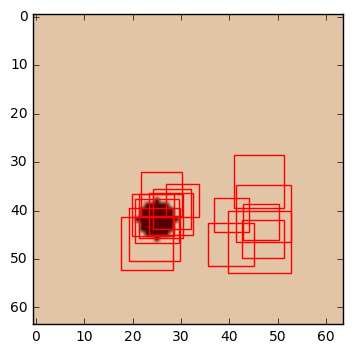

In [88]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

print(np.argmax(probs_, axis=1))

plt.imshow(image_)
Axs = plt.gca()

for i in range(proposal_.shape[0]):
    box = proposal_[i]
    rec = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], 
                           edgecolor="r", facecolor="none")
    Axs.add_patch(rec)

In [33]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [34]:
def anchor_refinement(boxes, deltas):
    boxes = tf.cast(boxes, tf.float32)
    h = boxes[:, 2] - boxes[:, 0]
    w = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + h / 2
    center_x = boxes[:, 1] + w / 2

    center_y += deltas[:, 0] * h
    center_x += deltas[:, 1] * w
    h *= tf.exp(deltas[:, 2])
    w *= tf.exp(deltas[:, 3])
    
    y1 = center_y - h / 2
    x1 = center_x - w / 2
    y2 = center_y + h / 2
    x2 = center_x + w / 2
    boxes = tf.stack([y1, x1, y2, x2], axis=1)
    return boxes

In [35]:
deltas_infe = out[-1][ix]
deltas_infe.shape

(16, 4, 4)

In [36]:
out[-1].shape

(20, 16, 4, 4)

In [45]:
ixs = np.argmax(probs_, axis=1)

deltas = deltas_infe[np.arange(16), ixs, :]

In [38]:
refined_rois = anchor_refinement(tf.cast(proposal_ / 64, tf.float32),
                                 tf.cast(deltas * config.RPN_BBOX_STD_DEV, tf.float32))

In [48]:
refined_rois_ = sess.run(refined_rois) * 64

In [40]:
positive_ixs = np.where(ixs > 0.4)[0]

positive_ixs

array([0, 2, 5])

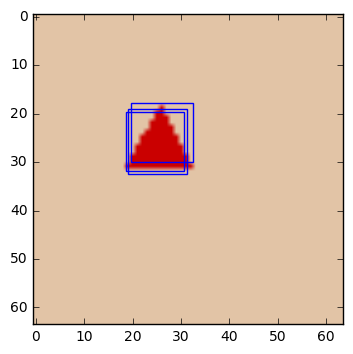

In [41]:
plt.imshow(image_)
Axs = plt.gca()

for i in range(positive_ixs.shape[0]):
    box = refined_rois_[positive_ixs[i]]
    rec = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], 
                           edgecolor="b", facecolor="none")
    Axs.add_patch(rec)